### This exercise is designed to pair with [this tutorial](https://www.kaggle.com/rtatman/bigquery-machine-learning-tutorial). If you haven't taken a look at it yet, head over and check it out first. (Otherwise these exercises will be pretty confusing!) -- Rachael 

# Stocking rental bikes

![bike rentals](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a0/Bay_Area_Bike_Share_launch_in_San_Jose_CA.jpg/640px-Bay_Area_Bike_Share_launch_in_San_Jose_CA.jpg)

You stock bikes for a bike rental company in Austin, ensuring stations have enough bikes for all their riders. You decide to build a model to predict how many riders will start from each station during each hour, capturing patterns in seasonality, time of day, day of the week, etc.

To get started, create a project in GCP and connect to it by running the code cell below. Make sure you have connected the kernel to your GCP account in Settings.

In [1]:
# Set your own project id here
PROJECT_ID = 'kaggle-bqml-pchlq' # a string, like 'kaggle-bigquery-240818'

from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID, location="US")
dataset = client.create_dataset('model_dataset', exists_ok=True)

from google.cloud.bigquery import magics
from kaggle.gcp import KaggleKernelCredentials
magics.context.credentials = KaggleKernelCredentials()
magics.context.project = PROJECT_ID

In [2]:
%load_ext google.cloud.bigquery

## Linear Regression

Your dataset is quite large. BigQuery is especially efficient with large datasets, so you'll use BigQuery-ML (called BQML) to build your model. BQML uses a "linear regression" model when predicting numeric outcomes, like the number of riders.

## 1) Training vs testing

You'll want to test your model on data it hasn't seen before (for reasons described in the [Intro to Machine Learning Micro-Course](https://www.kaggle.com/learn/intro-to-machine-learning). What do you think is a good approach to splitting the data? What data should we use to train, what data should we use for test the model?

We have to split data on training and holdout datasets with proportions, let's say, 70:30 respectively.

## Training data

First, you'll write a query to get the data for model-building. You can use the public Austin bike share dataset from the `bigquery-public-data.austin_bikeshare.bikeshare_trips` table. You predict the number of rides based on the station where the trip starts and the hour when the trip started. Use the `TIMESTAMP_TRUNC` function to truncate the start time to the hour.

In [3]:
# create a reference to our table
table = client.get_table("bigquery-public-data.austin_bikeshare.bikeshare_trips")

# look at five rows from our dataset
client.list_rows(table, max_results=5).to_dataframe()

,trip_id,subscriber_type,bikeid,start_time,start_station_id,start_station_name,end_station_id,end_station_name,duration_minutes
0,9900285908,Annual Membership (Austin B-cycle),400,2014-10-26 14:12:00+00:00,2823,Capital Metro HQ - East 5th at Broadway,2544,East 6th & Pedernales St.,10
1,9900289692,Walk Up,248,2015-10-02 21:12:01+00:00,1006,Zilker Park West,1008,Nueces @ 3rd,39
2,9900285987,24-Hour Kiosk (Austin B-cycle),446,2014-10-26 15:12:00+00:00,2712,Toomey Rd @ South Lamar,2712,Toomey Rd @ South Lamar,31
3,9900285989,24-Hour Kiosk (Austin B-cycle),203,2014-10-26 15:12:00+00:00,2712,Toomey Rd @ South Lamar,2712,Toomey Rd @ South Lamar,31
4,9900285991,24-Hour Kiosk (Austin B-cycle),101,2014-10-26 15:12:00+00:00,2712,Toomey Rd @ South Lamar,2712,Toomey Rd @ South Lamar,30


## 2) Exercise: Query the training data

Write the query to retrieve your training data. The fields should be:
1. The start_station_name
2. A time trips start, to the nearest hour. Get this with `TIMESTAMP_TRUNC(start_time, HOUR) as start_hour`
3. The number of rides starting at the station during the hour. Call this `num_rides`.
Select only the data before 2018-01-01 (so we can save data from 2018 as testing data.)

Write your query below:

In [4]:
%%bigquery train_df
SELECT 
    start_station_name,
    TIMESTAMP_TRUNC(start_time, HOUR) as start_hour,
    COUNT(1) AS num_rides
FROM
    `bigquery-public-data.austin_bikeshare.bikeshare_trips`
WHERE 
    EXTRACT(YEAR FROM start_time) < 2018
GROUP BY
    start_station_name, start_hour

You'll want to inspect your data to ensure it looks like what you expect. Run the line below to get a quick view of the data, and feel free to explore it more if you'd like (if you don't know how to do that, the [Pandas micro-course](https://www.kaggle.com/learn/pandas)) might be helpful.

In [5]:
train_df.head()

,start_station_name,start_hour,num_rides
0,Zilker Park West,2015-10-02 21:00:00+00:00,88
1,Zilker Park West,2015-10-02 20:00:00+00:00,23
2,Zilker Park West,2015-10-03 21:00:00+00:00,78
3,Nueces @ 3rd,2015-10-03 12:00:00+00:00,11
4,Zilker Park West,2015-10-03 16:00:00+00:00,12


In [6]:
train_df.groupby('start_station_name')['num_rides'].sum()

start_station_name
11th & San Jacinto                                       3451
13th & San Antonio                                        794
17th & Guadalupe                                         7856
2nd & Congress                                          29283
3rd & West                                              17774
                                                        ...  
Waller & 6th St.                                         5744
West & 6th St.                                          12741
Zilker Park                                             15176
Zilker Park West                                         1361
Zilker Park at Barton Springs & William Barton Drive    11534
Name: num_rides, Length: 91, dtype: int64

## Model creation

Now it's time to turn this data into a model. You'll use the `CREATE MODEL` statement that has a structure like: 

```sql
CREATE OR REPLACE MODEL`model_dataset.bike_trips`
OPTIONS(model_type='linear_reg') AS 
-- training data query goes here
SELECT ...
    column_with_labels AS label
    column_with_data_1 
    column_with_data_2
FROM ... 
WHERE ... (Optional)
GROUP BY ... (Optional)
```

The `model_type` and `optimize_strategy` shown here are good parameters to use in general for predicting numeric outcomes with BQML.

**Tip:** Using ```CREATE OR REPLACE MODEL``` rather than just ```CREATE MODEL``` ensures you don't get an error if you want to run this command again without first deleting the model you've created.

## 3) Exercise: Create and train the model

Below, write your query to create and train a linear regression model on the training data.

Write your query below:

In [7]:
%%bigquery

CREATE OR REPLACE MODEL`model_dataset.bike_trips`
OPTIONS(model_type='linear_reg', ls_init_learn_rate=.15, l1_reg=1, max_iterations=3) AS 
SELECT
    COUNT(1) AS label,
    start_station_name, 
    TIMESTAMP_TRUNC(start_time, HOUR) as start_hour
FROM `bigquery-public-data.austin_bikeshare.bikeshare_trips`
WHERE 
    EXTRACT(YEAR FROM start_time) < 2018
GROUP BY
    start_station_name, start_hour

""


# Get training statistics

In [8]:
%%bigquery
SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `model_dataset.bike_trips`)
ORDER BY iteration 

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,4.686611,3.979912,0.15,11536
1,0,1,4.002102,3.278119,0.15,14410
2,0,2,3.844480,3.146704,0.15,14797


## 4) Exercise: Model evaluation

Now that you have a model, evaluate it's performance on data from 2018. 


> Note that the ML.EVALUATE function will return different metrics depending on what's appropriate for your specific model. You can just use the regular ML.EVALUATE funciton here. (ROC curves are generally used to evaluate binary problems, not linear regression, so there's no reason to plot one here.)

Write your query below:

In [9]:
%%bigquery

SELECT
  *
FROM ML.EVALUATE(MODEL `model_dataset.bike_trips`, (
  SELECT
    COUNT(1) AS label,
    start_station_name, 
    TIMESTAMP_TRUNC(start_time, HOUR) as start_hour
  FROM `bigquery-public-data.austin_bikeshare.bikeshare_trips`
  WHERE 
    EXTRACT(YEAR FROM start_time) >= 2018
  GROUP BY
    start_station_name, start_hour))

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,1.733668,13.326763,0.314043,0.886895,-0.074314,-0.012991


You should see that the r^2 score here is negative. Negative values indicate that the model is worse than just predicting the mean rides for each example.

## 5) Theories for poor performance

Why would your model be doing worse than making the most simple prediction based on historical data?

*Because training and test sets need to put in order by timestamp and, perhaps, log-transformation target as well.*

## 6) Exercise: Looking at predictions

A good way to figure out where your model is going wrong is to look closer at a small set of predictions. Use your model to predict the number of rides for the 22nd & Pearl station in 2018. Compare the mean values of predicted vs actual riders.

Write your query below:

In [10]:
%%bigquery

SELECT
  *
FROM ML.EVALUATE(MODEL `model_dataset.bike_trips`, (
  SELECT
    COUNT(1) AS label,
    start_station_name, 
    TIMESTAMP_TRUNC(start_time, HOUR) as start_hour
  FROM `bigquery-public-data.austin_bikeshare.bikeshare_trips`
  WHERE 
    EXTRACT(YEAR FROM start_time) = 2018 AND
    start_station_name LIKE "%22nd & Pearl%"   
  GROUP BY
    start_station_name, start_hour))

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,2.606061,15.885672,0.537314,1.323319,-0.46932,0.015732


In [11]:
%%bigquery

SELECT
    AVG(cnt) AS avg_value
FROM
    (SELECT
        COUNT(1) AS cnt,
        start_station_name, 
        TIMESTAMP_TRUNC(start_time, HOUR) as start_hour
    FROM `bigquery-public-data.austin_bikeshare.bikeshare_trips`
    WHERE 
        EXTRACT(YEAR FROM start_time) = 2018 AND
        start_station_name LIKE "%22nd & Pearl%"   
    GROUP BY
        start_station_name, start_hour)

,avg_value
0,3.954864


What you should see here is that the model is underestimating the number of rides by quite a bit. 

## 7) Exercise: Average daily rides per station

Either something is wrong with the model or something surprising is happening in the 2018 data. 

What could be happening in the data? Write a query to get the average number of riders per station for each year in the dataset and order by the year so you can see the trend. You can use the `EXTRACT` method to get the day and year from the start time timestamp. (You can read up on EXTRACT [in this lesson in the Intro to SQL course](https://www.kaggle.com/dansbecker/order-by)). 

Write your query below:

In [12]:
%%bigquery avg_per_year

WITH Year_Riders AS
    (
        SELECT 
            start_station_name,
            EXTRACT(YEAR FROM start_time) as year,
            COUNT(1) AS num_riders
        FROM
            `bigquery-public-data.austin_bikeshare.bikeshare_trips`
        GROUP BY
            start_station_name, year
    )
SELECT start_station_name,
        year,
         AVG(num_riders) AS avg_riders
FROM Year_Riders
GROUP BY start_station_name, year
ORDER BY year DESC
    

In [13]:
avg_per_year.head()

,start_station_name,year,avg_riders
0,11th & Salina,2019,646.0
1,6th & Chalmers,2019,387.0
2,Medina & East 6th,2019,290.0
3,Red River/Cesar Chavez @ The Fairmont,2019,490.0
4,Henderson & 9th,2019,342.0


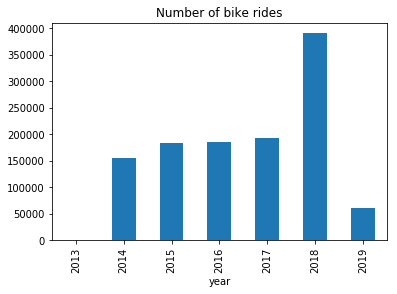

In [14]:
import matplotlib
avg_per_year.groupby('year')['avg_riders'].sum().plot(kind='bar')
matplotlib.pyplot.title("Number of bike rides");

## 8) What do your results tell you?

Given the daily average riders per station over the years, does it make sense that the model is failing?

***As we can see on the plot above, 2018 - is the year with unusual love for cycling.***

# 9) Next steps

Given what you've learned, what improvements do you think you could make to your model? Share your ideas on the [Kaggle Learn Forums](https://www.kaggle.com/learn-forum)! (I'll pick a couple of my favorite ideas & send the folks who shared them a Kaggle t-shirt. :)